## 0. Fashion dataset (*)
Zalando has provided an MNIST dataset for fashion, with the format very similar to the original MNIST digits dataset. Start with loading this fashion dataset from TensorFlow Keras.

a) Start visualizing some of the sample images

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import random

In [2]:
(X_train, y_train), (X_test, y_test) = load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
def display_images(data:np.array, nrows:int=2, ncols:int=5, figsize:tuple=(12, 4), title:str=None):
    """Displays nrows*ncols images."""
    
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.set_title(title)
        ax.imshow(data[i,:,:], cmap="gray") #0-9 and all rows and columns
        ax.axis("off")
        
    fig.tight_layout()

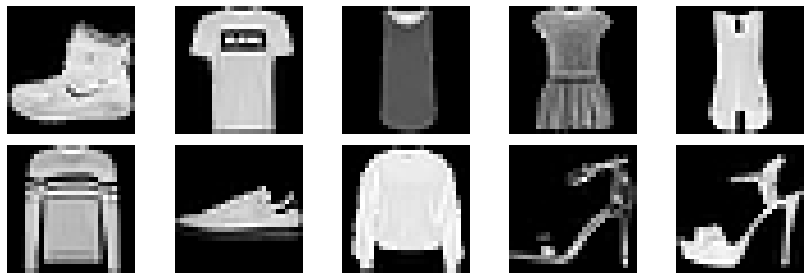

In [4]:
display_images(X_train)

b) Normalize the images to values between 0 and 1

In [5]:
X_train_norm = X_train.astype("float32")/255
X_test_norm = X_test.astype("float32")/255

In [6]:
X_train_norm.min(), X_train_norm.max(), X_test_norm.min(), X_train_norm.max()

(0.0, 1.0, 0.0, 1.0)

c) Visualize same images as before, do you see any difference?

In [ ]:
display_images(X_train_norm)

They look the same. 

d) Make histogram of a sample image before and after normalization. What do you notice?

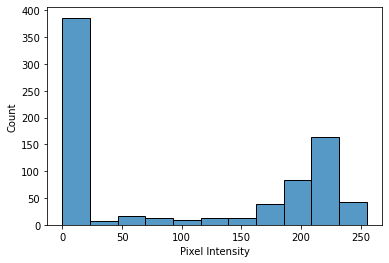

In [7]:
sns.histplot(X_train[0,:,:].flatten()).set(xlabel="Pixel Intensity");

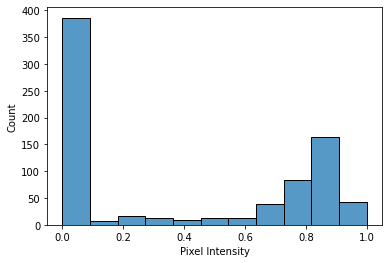

In [8]:
sns.histplot(X_train_norm[0,:,:].flatten()).set(xlabel="Pixel Intensity");

They are the same, except that the range before normalisation is 0 to 255 and after normalisation 0 to 1. 

e) Check if the dataset is balanced.

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
occurences = dict(zip(unique, counts))
occurences

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
occurences = dict(zip(unique, counts))
occurences

The dataset is balanced. 

0	T-shirt/top <br>
1	Trouser <br>
2	Pullover <br>
3	Dress <br>
4	Coat <br>
5	Sandal <br>
6	Shirt <br>
7	Sneaker <br>
8	Bag <br>
9	Ankle boot <br>

## 1. MLP architecture (*)
As we know from the lectures, there are no certain mathematical rules for choosing number of nodes and hidden layers. What we can do is to do trial and error, but it would be expensive to not have any guidelines. Look at this video and this blog article for rule of thumbs. Note that this will be computationally expensive on your laptop for larger networks and higher resolution images. Log in to kaggle and create a jupyter notebook inside kaggle and enable GPU. Remember to shut off the GPU after you're done with your work, you get a certain amount of quotas every week.

a) Create a network with no hidden layers, fit the model for 50 epochs. Use 10000 samples for validation.

In [9]:
def create_model_MLP(number_of_hidden_layers:int=0, number_of_nodes:list=None, dropout_rate:float=None, gaussian_noise:float=None, optimizer="adam"):
    """Creates an MLP model."""

    model_MLP = Sequential(name = "MLP") # Here we add the input layer
    model_MLP.add(Flatten(input_shape=(28, 28), name="Input_layer")) # We specify the number of features
    if gaussian_noise:
        model_MLP.add(GaussianNoise(gaussian_noise, input_shape=(784,)))
    
    if number_of_hidden_layers != 0:
        for layer, node in zip(range(1, number_of_hidden_layers+1), number_of_nodes):
            model_MLP.add(Dense(node, activation="relu", name=f"Hidden_layer_{layer}"))
            if dropout_rate:
                model_MLP.add(Dropout(dropout_rate, name=f"Dropout_{layer}"))
    model_MLP.add(Dense(10, name = "Output_layer", activation="softmax")) 

    model_MLP.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
    
    return model_MLP

In [11]:
model_without_hidden = create_model_MLP()
model_without_hidden.summary()

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Flatten)        (None, 784)               0         
_________________________________________________________________
Output_layer (Dense)         (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_without_hidden.fit(X_train_norm, y_train, validation_split=1/6, epochs=50, verbose=0)

b) Plot training loss vs validation loss and accuracy against validation accuracy.

In [14]:
def plot_metrics(model, style="-o", print_metrics=False):
    """
    Plot metrics specified in the model.
    If print_metrics = True, also prints out the
    first and last ten loss values."""
    
    metrics = pd.DataFrame(model.history.history)
    metrics.index = range(len(metrics))
    
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    columns = [["loss", "val_loss"], ["accuracy", "val_accuracy"]]

    for ax, col in zip(axes, columns):
        metrics.plot(y=col, xlabel="Epochs", ylabel=col[0], ax=ax, style=style)
        ax.grid()
        
    plt.show()
    
    if print_metrics == True:
        print(metrics[0:10])
        print("...")
        print(metrics[-10:-1])

In [ ]:
plot_metrics(model_without_hidden, print_metrics=True)

c) Repeat a) and b) for hidden_layers 1, 2, 3

In [13]:
def geometric_progression_of_2_closest_value(value, return_two_closest=False):
    """
    Gives the geometric progression of 2 of an input value.
    If return_two_closest is True then returns both
    the nearest lower and the nearest higher value. 
    """
    
    exponent = np.log2(value/2)
    exponent_lower_rounded = math.floor(exponent)
    exponent_upper_rounded = math.ceil(exponent)
    
    lower_value = 2**exponent_lower_rounded
    upper_value = 2**exponent_upper_rounded
    
    if return_two_closest == False:
        if np.abs(value/2 - lower_value) < np.abs(value/2 - upper_value):
            return lower_value
        else: 
            return upper_value
    else:
        return lower_value, upper_value 

In [ ]:
geometric_progression_of_2_closest_value(X_train_norm[0].flatten().shape[0])

In [ ]:
geometric_progression_of_2_closest_value(512)

In [ ]:
geometric_progression_of_2_closest_value(256)

In [ ]:
model_with_1_hidden = create_model_MLP(number_of_hidden_layers=1, number_of_nodes=[512])
model_with_1_hidden.summary()

In [ ]:
model_with_1_hidden.fit(X_train_norm, y_train, validation_split=1/6, epochs=50, verbose=0)

In [ ]:
plot_metrics(model_with_1_hidden, print_metrics=True)

In [ ]:
model_with_2_hidden = create_model_MLP(number_of_hidden_layers=2, number_of_nodes=[512, 256])
model_with_2_hidden.summary()

In [ ]:
model_with_2_hidden.fit(X_train_norm, y_train, validation_split=1/6, epochs=50, verbose=0)

In [ ]:
plot_metrics(model_with_2_hidden, print_metrics=True)

In [ ]:
model_with_3_hidden = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128])
model_with_3_hidden.summary()

In [ ]:
model_with_3_hidden.fit(X_train_norm, y_train, validation_split=1/6, epochs=50, verbose=0)

In [ ]:
plot_metrics(model_with_3_hidden, print_metrics=True)

d) Add dropout layers and choose a rate of dropout, and perform a few experiments. Note that you shouldn't add dropout layers after input layer and after output layer.

In [ ]:
model_with_3_hidden = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.5)
model_with_3_hidden.summary()

In [ ]:
model_with_3_hidden.fit(X_train_norm, y_train, validation_split=1/6, epochs=50, verbose=0)

In [ ]:
plot_metrics(model_with_3_hidden, print_metrics=True)

In [ ]:
model_with_3_hidden2 = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.2)
model_with_3_hidden2.fit(X_train_norm, y_train, validation_split=1/6, epochs=100, verbose=1)
plot_metrics(model_with_3_hidden2, print_metrics=True)

f) Define an experiment you want to investigate and perform it.

I want to test a gaussian blur filter and some other data augmentations techniques to see if this improves the model. However, first I tried to add some gaussian noise to the model. 

Epoch 1/100
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6030 - accuracy: 0.7845 - val_loss: 0.4241 - val_accuracy: 0.8450
Epoch 2/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.4262 - accuracy: 0.8469 - val_loss: 0.3812 - val_accuracy: 0.8631
Epoch 3/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3821 - accuracy: 0.8621 - val_loss: 0.3523 - val_accuracy: 0.8732
Epoch 4/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3561 - accuracy: 0.8709 - val_loss: 0.3447 - val_accuracy: 0.8750
Epoch 5/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3358 - accuracy: 0.8768 - val_loss: 0.3330 - val_accuracy: 0.8828
Epoch 6/100
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3182 - accuracy: 0.8836 - val_loss: 0.3242 - val_accuracy: 0.8831
Epoch 7/100
1563/1563 [==============================] - 4s 3ms/step - loss: 0.3065 - accuracy: 0.8883 - val_loss: 0.3346 - val_ac

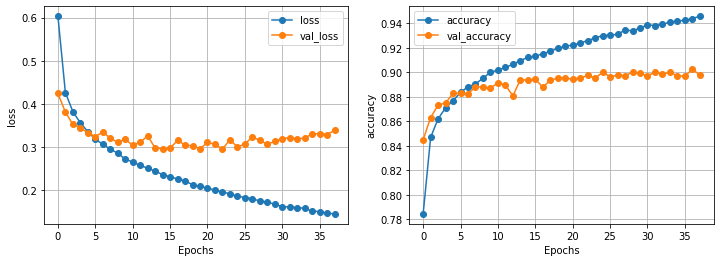

       loss  accuracy  val_loss  val_accuracy
0  0.603002   0.78448  0.424053        0.8450
1  0.426209   0.84688  0.381219        0.8631
2  0.382102   0.86208  0.352318        0.8732
3  0.356143   0.87092  0.344693        0.8750
4  0.335770   0.87678  0.332979        0.8828
5  0.318190   0.88358  0.324210        0.8831
6  0.306482   0.88826  0.334637        0.8824
7  0.295474   0.89034  0.320635        0.8881
8  0.285628   0.89526  0.310977        0.8881
9  0.272079   0.89998  0.318052        0.8871
...
        loss  accuracy  val_loss  val_accuracy
28  0.172049   0.93380  0.306416        0.9001
29  0.167945   0.93612  0.313421        0.8992
30  0.161725   0.93864  0.319329        0.8971
31  0.161221   0.93812  0.321890        0.9000
32  0.159888   0.93924  0.318935        0.8985
33  0.157897   0.94082  0.320787        0.8999
34  0.151868   0.94194  0.330551        0.8971
35  0.150434   0.94228  0.331109        0.8968
36  0.146721   0.94384  0.329033        0.9024


In [17]:
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=15, restore_best_weights=True)

model_with_3_hidden_noise = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.2, gaussian_noise=0.01, optimizer=Adamax())
model_with_3_hidden_noise.fit(X_train_norm, y_train, validation_split=1/6, callbacks=[early_stopper], epochs=100, verbose=1)
plot_metrics(model_with_3_hidden_noise, print_metrics=True)

This improved the model slightly. 

In [16]:
def add_noise(img): # Reference: https://stackoverflow.com/questions/43382045/keras-realtime-augmentation-adding-noise-and-contrast
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img


In [ ]:
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=25, restore_best_weights=True)

datagen = ImageDataGenerator(rescale=1./255,  
                             width_shift_range=0.2, 
                             height_shift_range=0.2,  
                             zoom_range=0.25, 
                             horizontal_flip=True, 
                             fill_mode='nearest', 
                             preprocessing_function=add_noise)

iterator = datagen.flow(X_train_norm.reshape(60000, 28, 28, 1), y_train)

model_with_3_hidden_aug = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.2, gaussian_noise=0.01, optimizer=Adamax())
model_with_3_hidden_aug.fit_generator(iterator)
model_with_3_hidden_aug.fit(X_train_norm, y_train, validation_split=1/6, callbacks=[early_stopper], epochs=150, verbose=1)

In [ ]:
plot_metrics(model_with_3_hidden_aug, print_metrics=True)

This did not improve the model. Next I will test it without scaling the data. 

In [ ]:
iterator = datagen.flow(X_train.reshape(60000, 28, 28, 1), y_train)

model_with_3_hidden_aug2 = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.2, gaussian_noise=0.01, optimizer=Adamax())
model_with_3_hidden_aug2.fit_generator(iterator)
model_with_3_hidden_aug2.fit(X_train_norm, y_train, validation_split=1/6, callbacks=[early_stopper], epochs=150, verbose=1)

In [ ]:
plot_metrics(model_with_3_hidden_aug2, print_metrics=True)

This did not improve the model. I also want to test it with less nodes. 

In [ ]:
geometric_progression_of_2_closest_value(X_train_norm[0].flatten().shape[0], return_two_closest=True)

In [ ]:
geometric_progression_of_2_closest_value(256)

In [ ]:
geometric_progression_of_2_closest_value(128)

In [ ]:
iterator = datagen.flow(X_train_norm.reshape(60000, 28, 28, 1), y_train)

model_with_3_hidden_aug3 = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[256, 128, 64], dropout_rate=0.2, gaussian_noise=0.01, optimizer=Adamax())
model_with_3_hidden_aug3.fit_generator(iterator)
model_with_3_hidden_aug3.fit(X_train_norm, y_train, validation_split=1/6, callbacks=[early_stopper], epochs=150, verbose=1)

In [ ]:
plot_metrics(model_with_3_hidden_aug3, print_metrics=True)

This did not improve the model. 

g) Choose a model from your experiments.

I will continue with model_with_3_hidden_noise, which is the model where I added some gaussian noise after the input layer and used early stopping, but did not do any data augmentation. 

d) Hidden layers are used to decrease overfitting. Can you see how it impacts your loss curves?

The loss of the training data goes down, but the loss for the validation data goes up. In this case, overfitting is worse with more hidden layers. I add a dropout layer and use early stopping to decrease overfitting. 

### 2. Predict and evaluate (*)
Use the model you've chosen from 1. and train on all training data. Also add early stopping to further avoid overfitting. Predict on the test data and evaluate your model.

In [19]:
final_model = create_model_MLP(number_of_hidden_layers=3, number_of_nodes=[512, 256, 128], dropout_rate=0.2, gaussian_noise=0.01, optimizer=Adamax())
final_model.fit(X_train_norm, y_train, epochs=36, verbose=1)

Epoch 1/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.5761 - accuracy: 0.7970
Epoch 2/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4106 - accuracy: 0.8518
Epoch 3/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3674 - accuracy: 0.8675
Epoch 4/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3444 - accuracy: 0.8744
Epoch 5/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3273 - accuracy: 0.8802
Epoch 6/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3114 - accuracy: 0.8858
Epoch 7/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2964 - accuracy: 0.8899
Epoch 8/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2846 - accuracy: 0.8947
Epoch 9/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2749 - accuracy: 0.8974
Epoch 10/36
1875/1875 [==============================] - 4s 2ms/step - loss: 0.265

              precision    recall  f1-score   support

           0     0.8446    0.8750    0.8595      1000
           1     0.9909    0.9830    0.9869      1000
           2     0.7928    0.8420    0.8167      1000
           3     0.9202    0.8990    0.9095      1000
           4     0.8280    0.8230    0.8255      1000
           5     0.9759    0.9730    0.9745      1000
           6     0.7585    0.7130    0.7351      1000
           7     0.9675    0.9530    0.9602      1000
           8     0.9789    0.9730    0.9759      1000
           9     0.9531    0.9750    0.9639      1000

    accuracy                         0.9009     10000
   macro avg     0.9010    0.9009    0.9008     10000
weighted avg     0.9010    0.9009    0.9008     10000



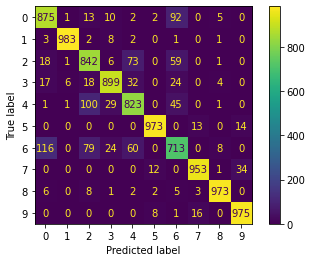

In [21]:
y_pred = final_model.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

a) Which item was hardest to classify? Do you have any ideas of why?

0 T-shirt/top <br>
1 Trouser <br>
2 Pullover <br>
3 Dress <br>
4 Coat <br>
5 Sandal <br>
6 Shirt <br>
7 Sneaker <br>
8 Bag <br>
9 Ankle boot <br>

Shirt was significantly hardest to classify, with only 713 out of 1000 correctly classified items. In 116 cases it was classified as T-shirt/top, in 60 cases it was classified as coat and in 79 cases it was classified as pullover. I believe this is becase shirt is a more general category, where pullover and T-shirt is a kind of shirt, and where a coat is quite similar. 

b) Show a few samples from each category that was misclassified.

In [22]:
df_y_test = pd.DataFrame({"Real":y_test})
df_y_pred = pd.DataFrame({"Predicted":y_pred})
results = pd.concat([df_y_test, df_y_pred], axis=1)
results["Correctly Classified"] = results["Real"] == results["Predicted"]
results

,Real,Predicted,Correctly Classified
0,9,9,True
1,2,2,True
2,1,1,True
3,1,1,True
4,6,6,True
...,...,...,...
9995,9,9,True
9996,1,1,True
9997,8,8,True
9998,1,1,True


In [23]:
incorrectly_classified = results[results["Correctly Classified"] == False]
incorrectly_classified

,Real,Predicted,Correctly Classified
12,7,5,False
17,4,2,False
23,9,5,False
29,3,6,False
40,6,0,False
...,...,...,...
9955,6,3,False
9961,6,2,False
9972,2,0,False
9977,6,0,False


In [24]:
incorrectly_classified_indexes = []

for i in range(10):
    incorrectly_classified_indexes.append(incorrectly_classified[incorrectly_classified["Real"] == i].index.values)

In [26]:
import pickle
with open('incorrectly_classified_indexes.pickle', 'wb') as handle:
    pickle.dump(incorrectly_classified_indexes,handle, protocol=pickle.HIGHEST_PROTOCOL)

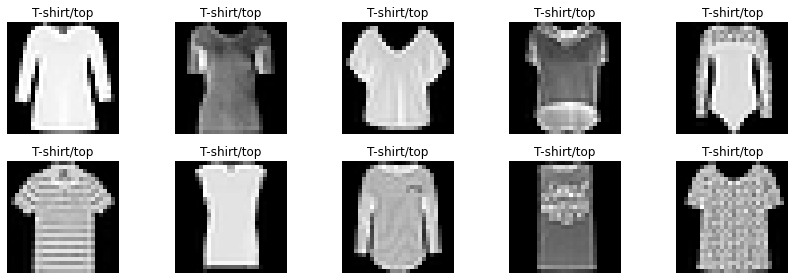

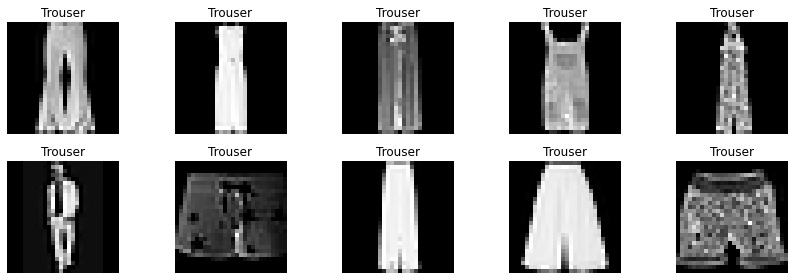

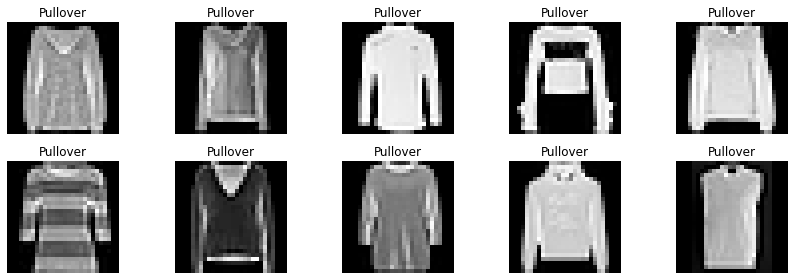

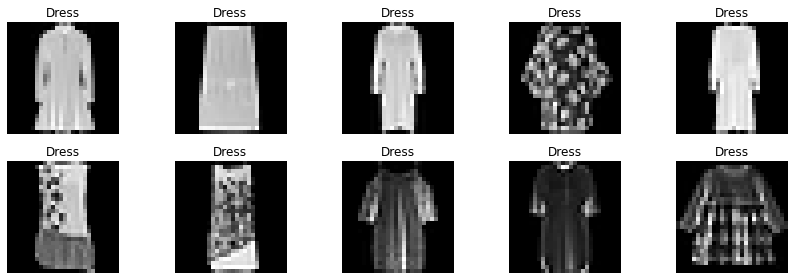

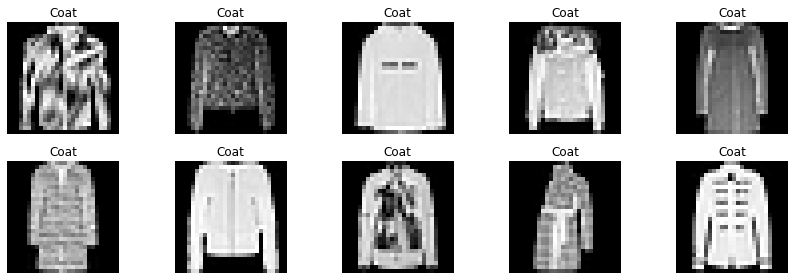

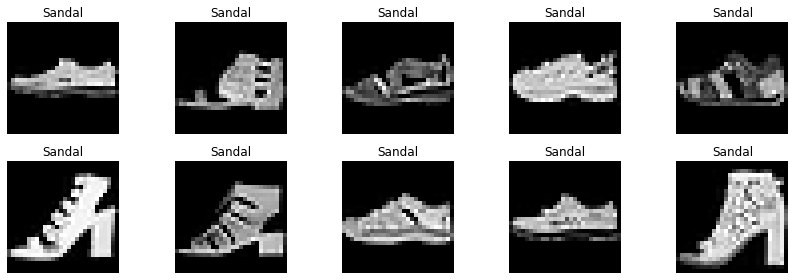

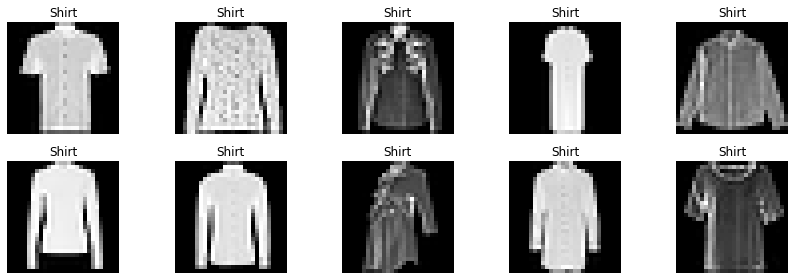

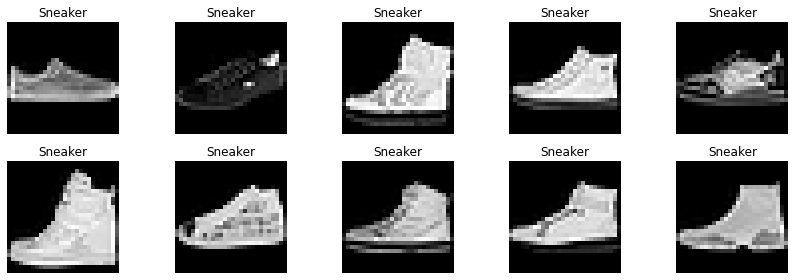

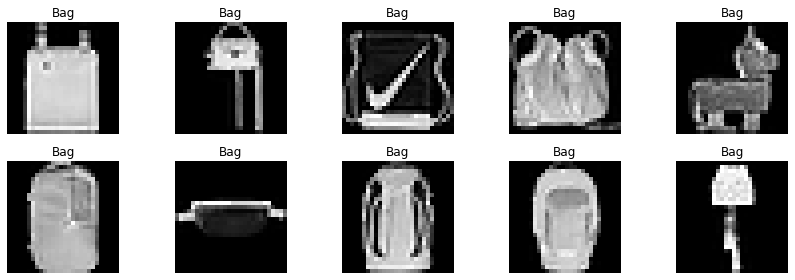

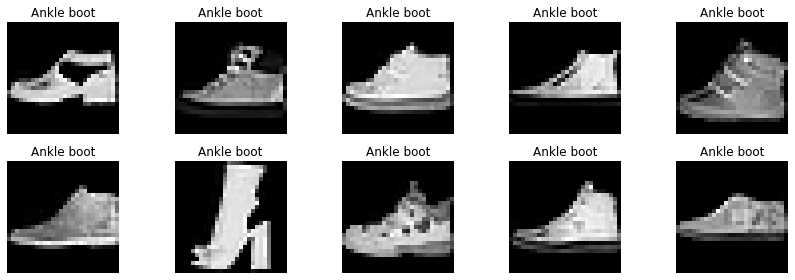

In [25]:
category_name = ["T-shirt/top", 
                 "Trouser", 
                 "Pullover", 
                 "Dress", 
                 "Coat", 
                 "Sandal", 
                 "Shirt", 
                 "Sneaker", 
                 "Bag",
                 "Ankle boot"]

for category, name in zip(incorrectly_classified_indexes, category_name):
    display_images(X_test[category], title=name)

c) Create a folder through Python called Misclassified and save the misclassified images there.

See VS code.